# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

# Assignment 3: KNN

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

## Mounting Google Drive locally

In [75]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [77]:
# using SQLite Table to read data.
con = sqlite3.connect("/content/gdrive/My Drive/Dataset/database.sqlite") 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [79]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [80]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [81]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [82]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [84]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [85]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [86]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [88]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [94]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:20<00:00, 2263.78it/s]


In [0]:
final["CleanText"] = [preprocessed_reviews[i] for i in range(len(final))]

# [4] Featurization

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score
import seaborn as sns

In [0]:
Total_X = final['CleanText'].values
Total_y = final['Score'].values

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(Total_X, Total_y, test_size=0.33)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 


In [172]:
print(f"Train Data : ({len(X_train)} , {len(y_train)})")
print(f"CV Data : ({len(X_cv)} , {len(y_cv)})")
print(f"Test Data : ({len(X_test)} , {len( y_test)})")

Train Data : (20680 , 20680)
CV Data : (10187 , 10187)
Test Data : (15204 , 15204)


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [103]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[1000:1010])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

some feature names  ['annual', 'annually', 'annuals', 'anonymous', 'anorexic', 'anosmia', 'another', 'anothert', 'anothorized', 'anount']
After vectorizations
(20680, 27192) (20680,)
(10187, 27192) (10187,)
(15204, 27192) (15204,)


100%|██████████| 15/15 [07:37<00:00, 31.27s/it]



The 'K' value 25 with highest roc_auc Score is 65.87832786546149


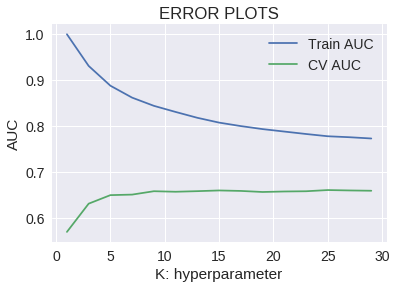

In [104]:
   
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in tqdm(K):
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "brute")
    knn.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  knn.predict_proba(X_cv_bow)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

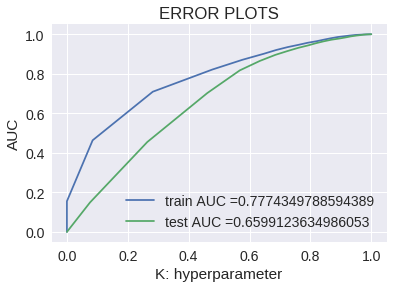

In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn = KNeighborsClassifier(n_neighbors=max_k, algorithm = "brute")
knn.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



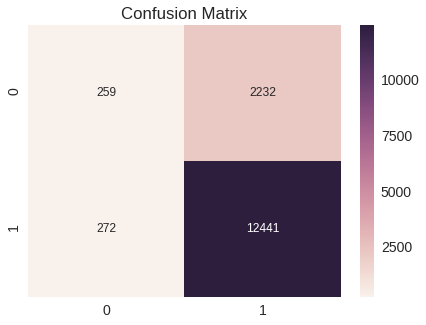

In [106]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, knn.predict(X_test_bow))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size


## [4.2] Bi-Grams and n-Grams.

In [107]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## TFIDF

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [174]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,  max_features=500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)


print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also']
After vectorizations
(20680, 500) (20680,)
(10187, 500) (10187,)
(15204, 500) (15204,)


100%|██████████| 15/15 [07:08<00:00, 29.17s/it]



The 'K' value 7 with highest roc_auc Score is 56.76463930713454


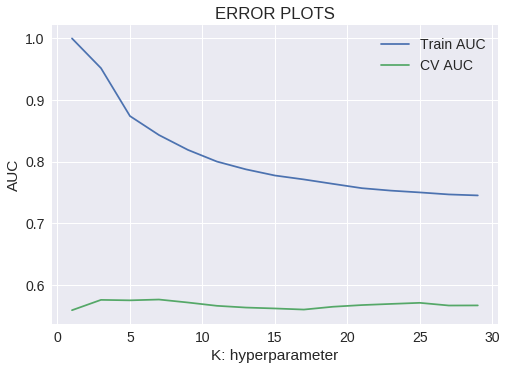

In [175]:
   
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in tqdm(K):
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "brute")
    knn.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  knn.predict_proba(X_cv_tfidf)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

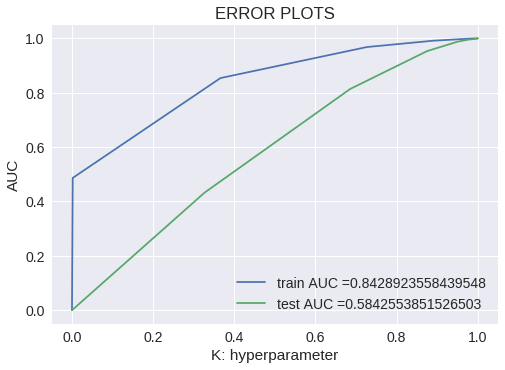

In [176]:
#Testing with Test data with best K

from sklearn.metrics import roc_curve, auc


knn = KNeighborsClassifier(n_neighbors=max_k, algorithm = "brute")
knn.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

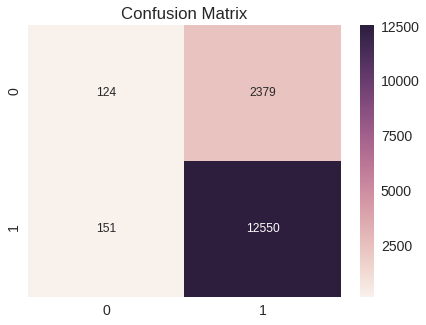

In [177]:
confusionMatrix=confusion_matrix(y_test, knn.predict(X_test_tfidf))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size

## [4.4] Word2Vec

In [0]:
i=0
w2v_train=[]
for sentance in X_train:
    w2v_train.append(sentance.split())

In [0]:
i=0
w2v_cv=[]
for sentance in X_cv:
    w2v_cv.append(sentance.split())

In [0]:
i=0
w2v_test=[]
for sentance in X_test:
    w2v_test.append(sentance.split())

In [181]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    #w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_model_train = Word2Vec(w2v_train,min_count=5,size=50, workers=4)
    w2v_model_cv = Word2Vec(w2v_cv,min_count=5,size=50, workers=4)
    w2v_model_test = Word2Vec(w2v_test,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print(w2v_model_cv.wv.most_similar('great'))
    print( w2v_model_test.wv.most_similar('great'))
    print('='*50)
    
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8433063626289368), ('wonderful', 0.803668200969696), ('excellent', 0.7970196008682251), ('fantastic', 0.7851126790046692), ('good', 0.7843843698501587), ('amazing', 0.7618692517280579), ('perfect', 0.7399687767028809), ('decent', 0.6859264969825745), ('terrific', 0.6598721742630005), ('delicious', 0.6402853727340698)]
[('good', 0.893620491027832), ('excellent', 0.8120091557502747), ('right', 0.7588951587677002), ('overall', 0.7552928328514099), ('reasonable', 0.7451762557029724), ('quick', 0.7378110289573669), ('makes', 0.7239895462989807), ('value', 0.723833441734314), ('works', 0.7212399244308472), ('decent', 0.7176932692527771)]
[('good', 0.842029333114624), ('amazing', 0.8009498715400696), ('excellent', 0.7650956511497498), ('wonderful', 0.7426431775093079), ('well', 0.732365071773529), ('fantastic', 0.7306373119354248), ('delicious', 0.7132661938667297), ('awesome', 0.7009203433990479), ('decent', 0.6960515379905701), ('perfect', 0.6708231568336487)]


In [182]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train ))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  8618
sample words  ['not', 'order', 'snack', 'sticks', 'amazon', 'decided', 'give', 'review', 'anyway', 'required', 'get', 'grams', 'protein', 'per', 'day', 'thought', 'would', 'try', 'based', 'many', 'positive', 'reviews', 'first', 'reluctant', 'eat', 'made', 'could', 'taste', 'anything', 'different', 'delicious', 'remind', 'slim', 'jim', 'lot', 'better', 'greasy', 'thicker', 'bit', 'difficult', 'chew', 'careful', 'also', 'filling', 'half', 'stick', 'time', 'highly', 'recommend', 'low']


In [183]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train ))
print("sample words ", w2v_words_cv[0:50])

number of words that occured minimum 5 times  8618
sample words  ['great', 'chip', 'low', 'sodium', 'high', 'fiber', 'nice', 'mild', 'balance', 'saltiness', 'perfectly', 'crisp', 'versatile', 'super', 'alone', 'salsa', 'delicious', 'cheese', 'everyone', 'serve', 'loves', 'surprised', 'healthy', 'gluten', 'free', 'also', 'nutritional', 'facts', 'check', 'website', 'searched', 'long', 'hard', 'find', 'good', 'decaf', 'not', 'lose', 'taste', 'smell', 'upon', 'brewing', 'one', 'sauces', 'use', 'refried', 'beans', 'awesome', 'started', 'using']


In [184]:
w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  7429
sample words  ['per', 'box', 'stop', 'shop', 'also', 'everyone', 'keeps', 'saying', 'nearly', 'identical', 'south', 'beach', 'bars', 'discontinued', 'back', 'still', 'available', 'time', 'ordered', 'product', 'not', 'first', 'took', 'chance', 'ordering', 'entire', 'case', 'however', 'oatmeal', 'delicious', 'actually', 'good', 'sugar', 'content', 'protein', 'high', 'tastes', 'like', 'pancake', 'cookie', 'batter', 'plus', 'super', 'metabolism', 'make', 'eat', 'breakfast', 'hungry', 'hour', 'later']


## Converting text into vectors using Avg W2V, TFIDF-W2V

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

#### [4.4.1.1] Avg W2v

In [185]:
train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print()
print(len(train_vectors))
print(len(train_vectors[0]))

100%|██████████| 20680/20680 [00:33<00:00, 621.26it/s]


20680
50


In [186]:
# average Word2Vec
# compute average word2vec for each review.
cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec)
print()
print(len(cv_vectors))
print(len(cv_vectors[0]))

100%|██████████| 10187/10187 [00:14<00:00, 712.18it/s]


10187
50


In [187]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print()
print(len(test_vectors))
print(len(test_vectors[0]))

100%|██████████| 15204/15204 [00:23<00:00, 654.80it/s]


15204
50


100%|██████████| 15/15 [03:30<00:00, 14.55s/it]



The 'K' value 29 with highest roc_auc Score is 74.13004377629464


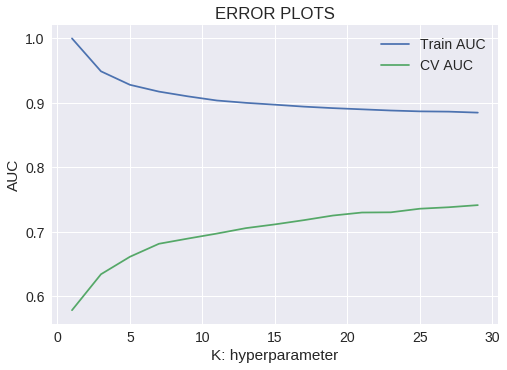

In [188]:
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in tqdm(K):
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "brute")
    knn.fit(train_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(train_vectors)[:,1]
    y_cv_pred =  knn.predict_proba(cv_vectors)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

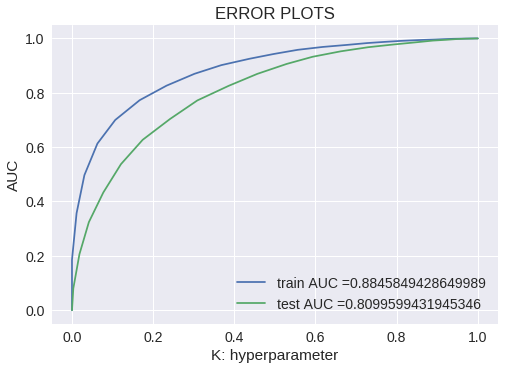

In [189]:
#Testing with Test data with best K

knn = KNeighborsClassifier(n_neighbors=29, algorithm = "brute")
knn.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



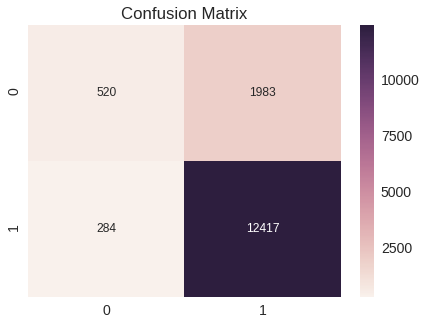

In [190]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")

confusionMatrix=confusion_matrix(y_test, knn.predict(test_vectors))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_1 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in w2v_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_2 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
()# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in w2v_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv and word in tfidf_feat:
            vec = w2v_model_cv.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_3 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in w2v_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_3[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1


The 'K' value 29 with highest roc_auc Score is 71.42586478806501


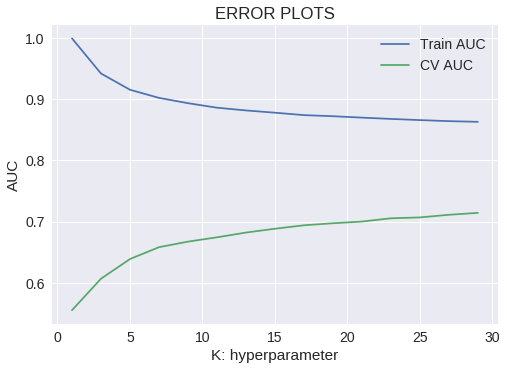

In [197]:
   
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in K:
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "brute")
    knn.fit(train_tfidf_sent_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(train_tfidf_sent_vectors)[:,1]
    y_cv_pred =  knn.predict_proba(cv_tfidf_sent_vectors)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

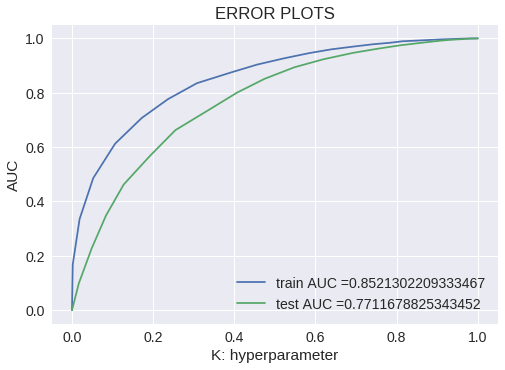

In [198]:
#Testing with Test data with best K

knn = KNeighborsClassifier(n_neighbors=max_k, algorithm = "brute")
knn.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(train_tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(test_tfidf_sent_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



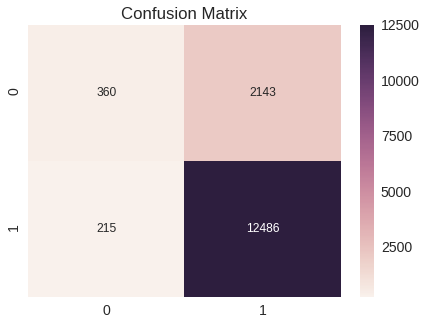

In [199]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, knn.predict(test_tfidf_sent_vectors))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
Total_X_ = final['CleanText'].values[:20000]
Total_y_ = final['Score'].values[:20000]

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(Total_X_, Total_y_, test_size=0.33)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 


In [136]:
print(f"Train Data : ({len(X_train)} , {len(y_train)})")
print(f"CV Data : ({len(X_cv)} , {len(y_cv)})")
print(f"Test Data : ({len(X_test)} , {len( y_test)})")

Train Data : (8978 , 8978)
CV Data : (4422 , 4422)
Test Data : (6600 , 6600)


In [137]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[10:20])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

some feature names  ['alternative', 'although', 'always', 'amazing', 'amazon', 'amount', 'another', 'anyone', 'anything', 'around']
After vectorizations
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


**NOTE**: sklearn implementation of kd-tree accepts only dense matrices, we need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. We  can convert sparse matrices to dense using .toarray() attribute.  [link]('https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html)

In [0]:
X_train_bow = X_train_bow.toarray()
X_cv_bow = X_cv_bow.toarray()
X_test_bow = X_test_bow.toarray()

100%|██████████| 15/15 [29:09<00:00, 119.75s/it]



The 'K' value 29 with highest roc_auc Score is 72.42573270106637


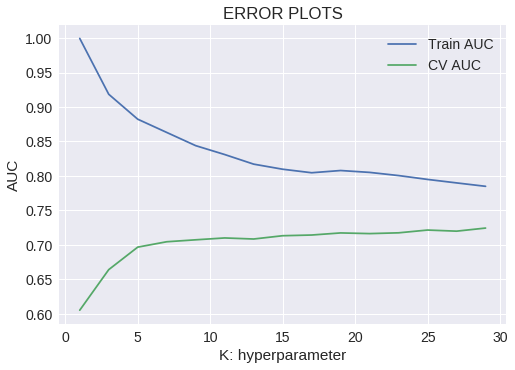

In [139]:
   
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in tqdm(K):
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "kd_tree")
    knn.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  knn.predict_proba(X_cv_bow)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

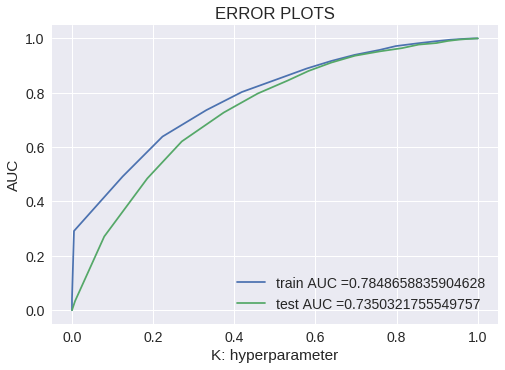

In [140]:
#Testing with Test data with best K

knn = KNeighborsClassifier(n_neighbors=max_k, algorithm = "kd_tree")
knn.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



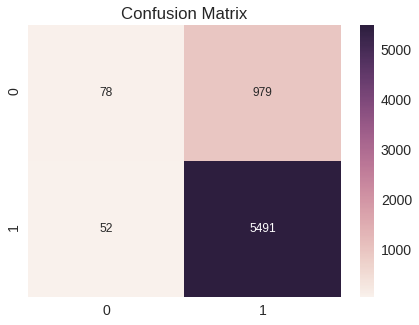

In [142]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, knn.predict(X_test_bow))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [143]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,  max_features=500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)


print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'already', 'also', 'alternative']
After vectorizations
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)


In [0]:
X_train_tfidf = X_train_tfidf.toarray()
X_cv_tfidf = X_cv_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

100%|██████████| 15/15 [01:31<00:00,  6.24s/it]



The 'K' value 29 with highest roc_auc Score is 61.04959647193002


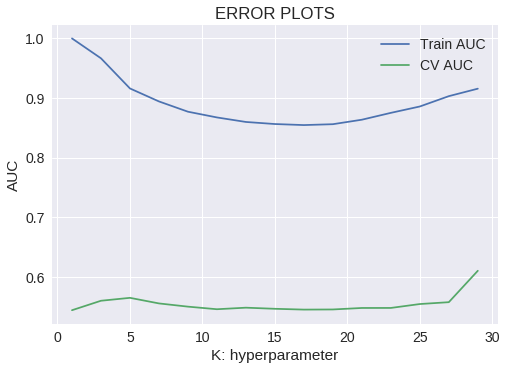

In [145]:
   
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in tqdm(K):
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "brute")
    knn.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  knn.predict_proba(X_cv_tfidf)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

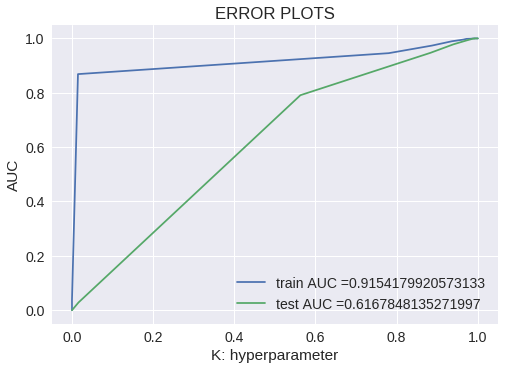

In [146]:
#Testing with Test data with best K

knn= KNeighborsClassifier(n_neighbors=max_k, algorithm = "brute")
knn.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



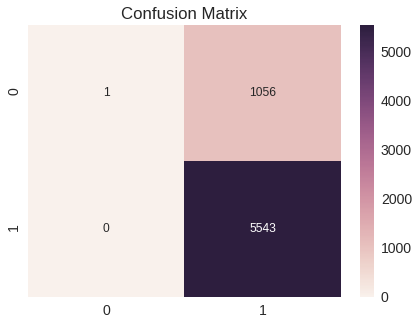

In [147]:

print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, knn.predict(X_test_tfidf))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")

## [4.4] Word2Vec

In [0]:
i=0
w2v_train=[]
for sentance in X_train:
    w2v_train.append(sentance.split())

In [0]:
i=0
w2v_cv=[]
for sentance in X_cv:
    w2v_cv.append(sentance.split())

In [0]:
i=0
w2v_test=[]
for sentance in X_test:
    w2v_test.append(sentance.split())

In [151]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    #w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_model_train = Word2Vec(w2v_train,min_count=5,size=50, workers=4)
    w2v_model_cv = Word2Vec(w2v_cv,min_count=5,size=50, workers=4)
    w2v_model_test = Word2Vec(w2v_test,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print(w2v_model_cv.wv.most_similar('great'))
    print( w2v_model_test.wv.most_similar('great'))
    print('='*50)
    
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8937122225761414), ('excellent', 0.8830335736274719), ('value', 0.8016687631607056), ('awesome', 0.794669508934021), ('makes', 0.7938923835754395), ('quick', 0.7900804281234741), ('especially', 0.7889974117279053), ('alternative', 0.7823800444602966), ('unbeatable', 0.7776635885238647), ('wonderful', 0.7769509553909302)]
[('dense', 0.997190535068512), ('fiber', 0.9971810579299927), ('excellent', 0.99708491563797), ('also', 0.9970830678939819), ('makes', 0.9970706701278687), ('sandwich', 0.9970347881317139), ('sweetener', 0.9970299601554871), ('grams', 0.9970104098320007), ('syrup', 0.9970079064369202), ('brown', 0.9970002770423889)]
[('good', 0.9503970146179199), ('excellent', 0.9497627019882202), ('tasty', 0.9378092885017395), ('also', 0.934010922908783), ('wonderful', 0.9315544366836548), ('bar', 0.9301097393035889), ('tasting', 0.926845371723175), ('calorie', 0.9263210892677307), ('makes', 0.9253037571907043), ('real', 0.9244411587715149)]


In [152]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train ))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  5749
sample words  ['great', 'different', 'types', 'rice', 'price', 'increasing', 'deal', 'plastic', 'containers', 'help', 'keep', 'fresh', 'directions', 'clear', 'cooked', 'cooker', 'stop', 'top', 'no', 'issues', 'recommend', 'anything', 'tried', 'dinner', 'last', 'night', 'enjoyed', 'immensely', 'flavor', 'rich', 'texture', 'definitely', 'one', 'hand', 'comfort', 'food', 'easy', 'prepare', 'instructions', 'recently', 'gone', 'gluten', 'free', 'still', 'learning', 'safe', 'eat', 'meals', 'bland', 'lately']


In [153]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train ))
print("sample words ", w2v_words_cv[0:50])

number of words that occured minimum 5 times  5749
sample words  ['great', 'northern', 'popcorn', 'popper', 'use', 'seems', 'used', 'almost', 'daily', 'since', 'year', 'old', 'girls', 'friends', 'always', 'wanting', 'snack', 'school', 'although', 'also', 'separate', 'corn', 'oil', 'packs', 'good', 'tasting', 'sometimes', 'little', 'hurry', 'ingredients', 'either', 'way', 'not', 'know', 'got', 'bad', 'batch', 'bag', 'pop', 'flavor', 'absolutely', 'horrible', 'smell', 'unopened', 'bags', 'like', 'bought', 'boxes', 'give', 'christmas']


In [154]:
w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  4725
sample words  ['stuff', 'smells', 'bad', 'looks', 'worse', 'cat', 'eat', 'anything', 'not', 'finicky', 'hungry', 'would', 'replaced', 'another', 'newmans', 'chicken', 'product', 'quickly', 'tins', 'useless', 'normally', 'try', 'buy', 'quantity', 'thought', 'brand', 'safe', 'salt', 'vinegar', 'chips', 'definitely', 'favorite', 'type', 'potato', 'chip', 'ones', 'made', 'kettle', 'tasty', 'enjoyed', 'thoroughly', 'wish', 'healthy', 'option', 'great', 'taste', 'popcorn', 'delicious', 'however', 'packages']


## Converting text into vectors using Avg W2V, TFIDF-W2V

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

#### [4.4.1.1] Avg W2v

In [155]:
train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print()
print(len(train_vectors))
print(len(train_vectors[0]))

100%|██████████| 8978/8978 [00:12<00:00, 710.95it/s]


8978
50


In [156]:
# average Word2Vec
# compute average word2vec for each review.
cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec)
print()
print(len(cv_vectors))
print(len(cv_vectors[0]))

100%|██████████| 4422/4422 [00:04<00:00, 894.46it/s]


4422
50


In [157]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(w2v_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print()
print(len(test_vectors))
print(len(test_vectors[0]))

100%|██████████| 6600/6600 [00:08<00:00, 794.51it/s]


6600
50


100%|██████████| 15/15 [02:09<00:00,  9.36s/it]



The 'K' value 29 with highest roc_auc Score is 53.84503595502609


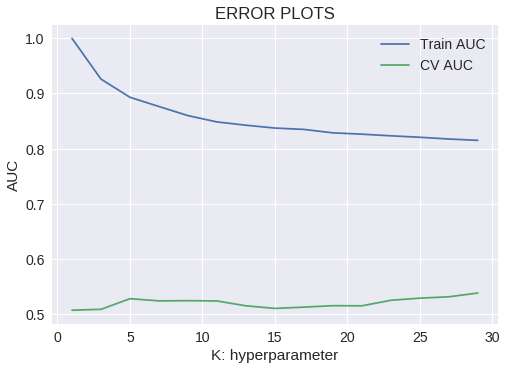

In [158]:
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in tqdm(K):
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "kd_tree")
    knn.fit(train_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(train_vectors)[:,1]
    y_cv_pred =  knn.predict_proba(cv_vectors)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

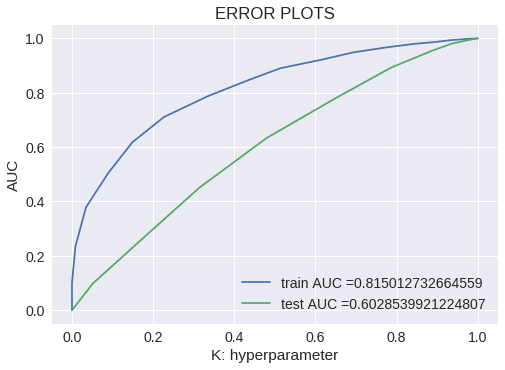

In [159]:
#Testing with Test data with best K

knn = KNeighborsClassifier(n_neighbors=max_k, algorithm = "kd_tree")
knn.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



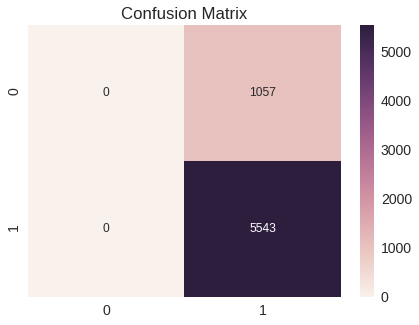

In [160]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")

confusionMatrix=confusion_matrix(y_test, knn.predict(test_vectors))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size

## TFIDF_W2V 
**SET_8**

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_1 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in w2v_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_2 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
()# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in w2v_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv and word in tfidf_feat:
            vec = w2v_model_cv.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_3 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in w2v_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_3[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1


The 'K' value 23 with highest roc_auc Score is 58.31448440814736


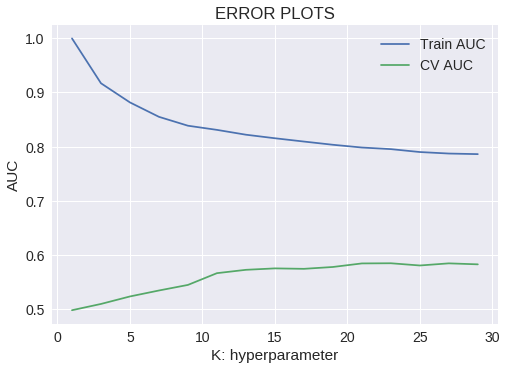

In [167]:
   
train_auc = []
cv_auc = []
max_k=0
max_roc_auc=-1
K = range(1,30,2)
for i in K:
    
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = "kd_tree")
    knn.fit(train_tfidf_sent_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  knn.predict_proba(train_tfidf_sent_vectors)[:,1]
    y_cv_pred =  knn.predict_proba(cv_tfidf_sent_vectors)[:,1]
        
    #proba1 =roc_auc_score(y_train,y_train_pred) * float(100)
    proba2 = roc_auc_score(y_cv, y_cv_pred) * float(100)    
    
    if(max_roc_auc<proba2):
        max_roc_auc=proba2
        max_k=i
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {proba2}" ) 
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

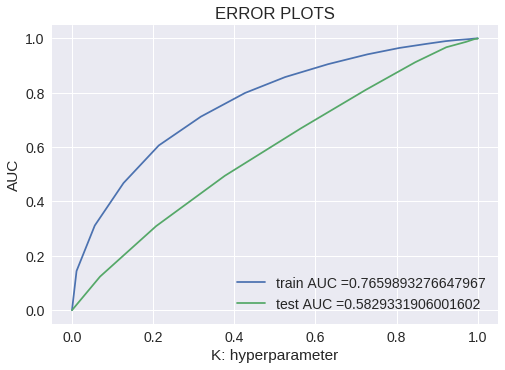

In [168]:
#Testing with Test data with best K

knn = KNeighborsClassifier(n_neighbors=max_k, algorithm = "kd_tree")
knn.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, knn.predict_proba(train_tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn.predict_proba(test_tfidf_sent_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Confusion Matrix of test set:
 [ [TN  FP]
   [FN TP] ]



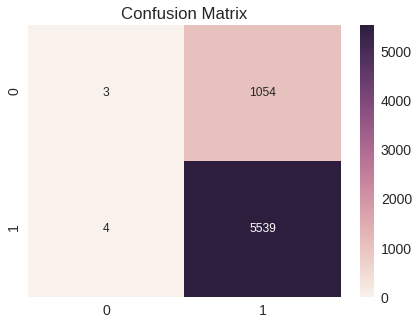

In [169]:
print("\nConfusion Matrix of test set:\n [ [TN  FP]\n   [FN TP] ]\n")
confusionMatrix=confusion_matrix(y_test, knn.predict(test_tfidf_sent_vectors))
df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
plt.figure(figsize = (7,5))
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size

# [6] Conclusions

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
y = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter(K)","Test AUC"]
y.field_names = ["Vectorizer", "Model", "Hyper parameter(K)","Test AUC"]

x.add_row(["BoW","Brute",25,0.65])
x.add_row(["Tf-Idf","Brute", 7,0.58])
x.add_row(["Avg Word2Vec","Brute",29,0.80])
x.add_row(["tf idf-Word2vec","Brute",29,0.77])

y.add_row(["BoW","kd_tree",29,0.73])
y.add_row(["Tf-Idf","kd_tree", 29,0.61])
y.add_row(["Avg Word2Vec","kd_tree",29,0.60])
y.add_row(["tf idf-Word2vec","kd_tree",23,0.58])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('**Conclusion:**')
print(x)
print(y)

**Conclusion:**

+-----------------+-------+--------------------+----------+
|    Vectorizer   | Model | Hyper parameter(K) | Test AUC |
+-----------------+-------+--------------------+----------+
|       BoW       | Brute |         25         |   0.65   |
|      Tf-Idf     | Brute |         7          |   0.58   |
|   Avg Word2Vec  | Brute |         29         |   0.8    |
| tf idf-Word2vec | Brute |         29         |   0.77   |
+-----------------+-------+--------------------+----------+
+-----------------+---------+--------------------+----------+
|    Vectorizer   |  Model  | Hyper parameter(K) | Test AUC |
+-----------------+---------+--------------------+----------+
|       BoW       | kd_tree |         29         |   0.73   |
|      Tf-Idf     | kd_tree |         29         |   0.61   |
|   Avg Word2Vec  | kd_tree |         29         |   0.6    |
| tf idf-Word2vec | kd_tree |         23         |   0.58   |
+-----------------+---------+--------------------+----------+


* Based on confusion matrix we can say that this model more biased towards positive values.

* Finally we can pick the Best Model in which we can see highest Test AUC(unseen data) so that we can predict probability on the future unseen data(review in our case).

* Test accuracy(unseen data) using KNN brute force:
        

1. Avg Word2Vec has predicted 80% accurate on test data using Brute force.
2.  BoW has predicted 73% accurate on test data using Kd_tree.